In [1]:
%load_ext skip_kernel_extension

import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)


In [2]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
import keras_tuner as kt


In [4]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [5]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = True

## Loading Data

In [6]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [7]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


# Multistep LSTM

Scale the input data

In [8]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [9]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'price actual'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [10]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24,24,32)


In [11]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17464, 24, 26) (17464, 24)
(1336, 24, 26) (1336, 24)
(24, 24, 26) (24, 24)


Define LSTM Model

In [12]:
def build_model_ED_LSTM(hp):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential()
  # Encoder
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,input_shape=(None, n_features), stateful=False)) 
  model.add(layers.BatchNormalization())
  
  for i in range(hp.Int('n_layers',1,4,1)):
    model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
    model.add(layers.BatchNormalization())
  
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=False, stateful=False)) 
  model.add(layers.BatchNormalization())  
  
  # Repeat Vector
  model.add(layers.RepeatVector(n_timesteps))
  
  # Decoder
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
  model.add(layers.BatchNormalization())

  for i in range(hp.Int('n_layers',1,4,1)):
      model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
      model.add(layers.BatchNormalization())

  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
  model.add(layers.BatchNormalization())

  # End
  model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"))
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.BatchNormalization())
  model.add(layers.TimeDistributed(layers.Dense(1)))                     
              
  
  model.compile(optimizer='Adam',loss='mae',metrics='mse') 
  return model

In [13]:
tuner = kt.RandomSearch(
    build_model_ED_LSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial = 2,
    directory = "./hpt_ED_LSTM/",
    project_name="DDE")
tuner.search_space_summary()


INFO:tensorflow:Reloading Oracle from existing project ./hpt_ED_LSTM/DDE\oracle.json
INFO:tensorflow:Reloading Tuner from ./hpt_ED_LSTM/DDE\tuner0.json
Search space summary
Default search space size: 2
Neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}


In [14]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint("./EDLSTM/my_best_hpt_MS_ED_LSTM_model.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [15]:
num_epochs = 150
batch_size = 32

In [16]:
tuner.search(data_x_train,data_y_train,epochs=150,validation_data=(data_x_val,data_y_val),batch_size=batch_size,callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

INFO:tensorflow:Oracle triggered exit


In [17]:
tuner.results_summary()

Results summary
Results in ./hpt_ED_LSTM/DDE
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 3
Score: 10.074690341949463
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 4
Score: 10.227522850036621
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 3
Score: 10.876497268676758
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 4
Score: 11.198130130767822
Trial summary
Hyperparameters:
Neurons: 32
n_layers: 3
Score: 11.31832504272461
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 2
Score: 12.445674896240234
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 2
Score: 13.349409580230713
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 2
Score: 13.478788375854492
Trial summary
Hyperparameters:
Neurons: 32
n_layers: 2
Score: 13.664177417755127
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 1
Score: 15.003725051879883


In [18]:
best_models = tuner.get_best_models()
best_hps = tuner.get_best_hyperparameters(5)

In [19]:
best_hps[0]

In [21]:

model_LSTM= build_model_ED_LSTM(best_hps[0])
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

Epoch 1/150
546/546 [==============================] - 26s 35ms/step - loss: 44.9222 - mse: 2300.0242 - val_loss: 43.0719 - val_mse: 2268.6582
Epoch 2/150
546/546 [==============================] - 17s 32ms/step - loss: 13.6101 - mse: 309.5818 - val_loss: 18.5646 - val_mse: 494.9907
Epoch 3/150
546/546 [==============================] - 18s 33ms/step - loss: 8.6180 - mse: 122.2278 - val_loss: 16.8639 - val_mse: 411.3756
Epoch 4/150
546/546 [==============================] - 18s 33ms/step - loss: 8.0054 - mse: 106.3212 - val_loss: 16.7790 - val_mse: 393.4277
Epoch 5/150
546/546 [==============================] - 18s 33ms/step - loss: 7.5964 - mse: 95.5954 - val_loss: 15.4598 - val_mse: 341.0424
Epoch 6/150
546/546 [==============================] - 18s 32ms/step - loss: 7.0988 - mse: 85.2163 - val_loss: 15.3387 - val_mse: 344.2462
Epoch 7/150
546/546 [==============================] - 17s 32ms/step - loss: 6.4122 - mse: 71.4173 - val_loss: 14.4506 - val_mse: 306.7854
Epoch 8/150
546/546

Evaluate the training process

In [22]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

In [23]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,'LSTM','./EDLSTM/learning_curve_MS_hpt_ED_LSTM.png')
fig.show()

Load best model

In [24]:
#Calling back the best model:
model_best_MS_LSTM = keras.models.load_model("./EDLSTM/my_best_hpt_MS_ED_LSTM_model.h5")
model_best_MS_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, None, 80)          34240     
_________________________________________________________________
batch_normalization_22 (Batc (None, None, 80)          320       
_________________________________________________________________
lstm_21 (LSTM)               (None, None, 80)          51520     
_________________________________________________________________
batch_normalization_23 (Batc (None, None, 80)          320       
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 80)          51520     
_________________________________________________________________
batch_normalization_24 (Batc (None, None, 80)          320       
_________________________________________________________________
lstm_23 (LSTM)               (None, None, 80)         

In [25]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))

Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]


In [26]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-27-7acfb625daac>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


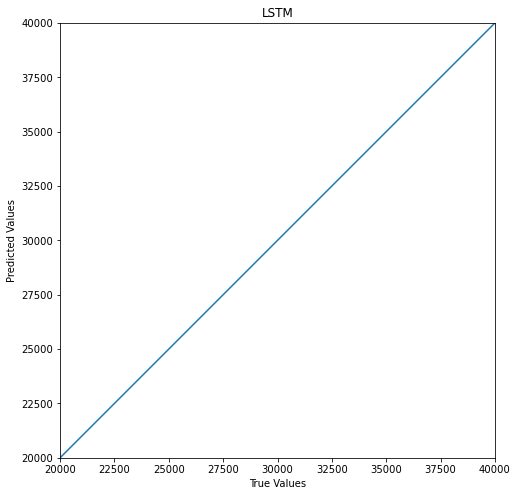

In [27]:
fig = plot_accuracy(eval_df,'LSTM',"./LSTM/accuracy_MS_hpt_LSTM.png")
fig.show()

<ipython-input-28-286c2bf8181f>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


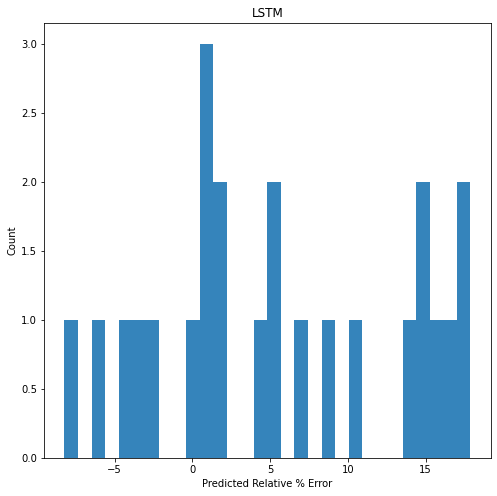

In [28]:
fig = plot_error_variations(eval_df,'LSTM',"./LSTM/error_variations_MS_hpt_LSTM.png")
fig.show()

In [29]:
#Calculating the mean absolutepercentage error:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

nan

In [30]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -0.75


<ipython-input-31-161827b186c6>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


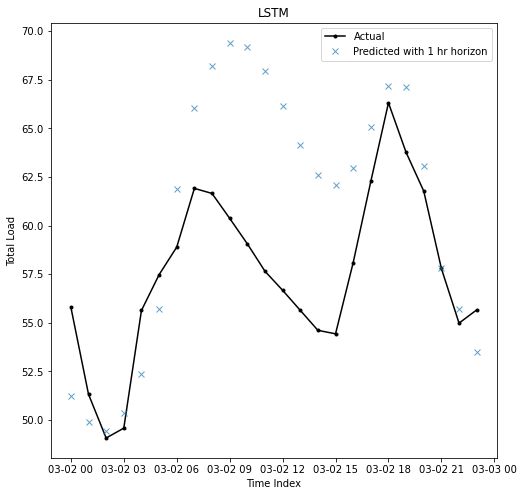

In [31]:
fig = plot_predictions(eval_df,1,'LSTM','Total Load',"./LSTM/predictions_MS_hpt_LSTM")
fig.show()

In [32]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [33]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2['price actual']))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [34]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -0.13
